# Thêm thư viện cần thiết


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 31.2 MB/s 
     |████████████████████████████████| 9.8 MB 56.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [4]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/eth/ethereum_train_9_1.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [5]:
train = train_ETH[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


In [6]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/9_1/eth/ethereum_test_9_1.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-03-21,2.86166,2.96042,2.83038,2.89163,546607,USD
2022-03-22,2.89141,3.04832,2.88769,2.96964,716472,USD
2022-03-23,2.96964,3.04228,2.92578,3.03612,536634,USD
2022-03-24,3.03618,3.12637,3.00599,3.10925,699579,USD
2022-03-25,3.11080,3.19273,3.08171,3.10351,583248,USD


In [7]:
test = test_ETH[["Close"]]
test.head(5)

,Close
Date,
2022-03-21,2.89163
2022-03-22,2.96964
2022-03-23,3.03612
2022-03-24,3.10925
2022-03-25,3.10351


In [8]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


# Vẽ đồ thị

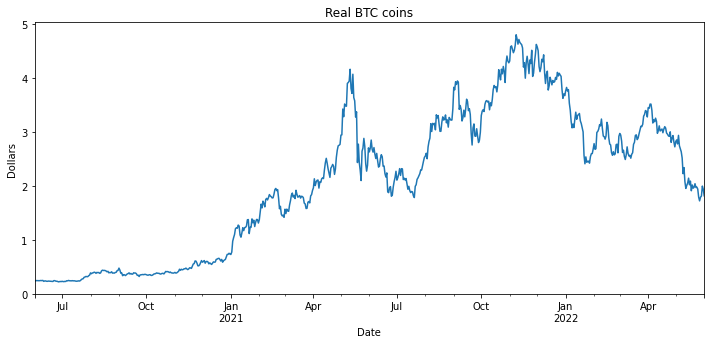

In [9]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Close'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [10]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [11]:
adf_test(df['Close'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.625923
p-value                     0.469625
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [12]:
df['diff1'] = df['Close'].diff()
df.head()


,Close,diff1
Date,,
2020-06-01,0.24797,NaN
2020-06-02,0.23794,-0.01003
2020-06-03,0.24452,0.00658
2020-06-04,0.24337,-0.00115
2020-06-05,0.24023,-0.00314


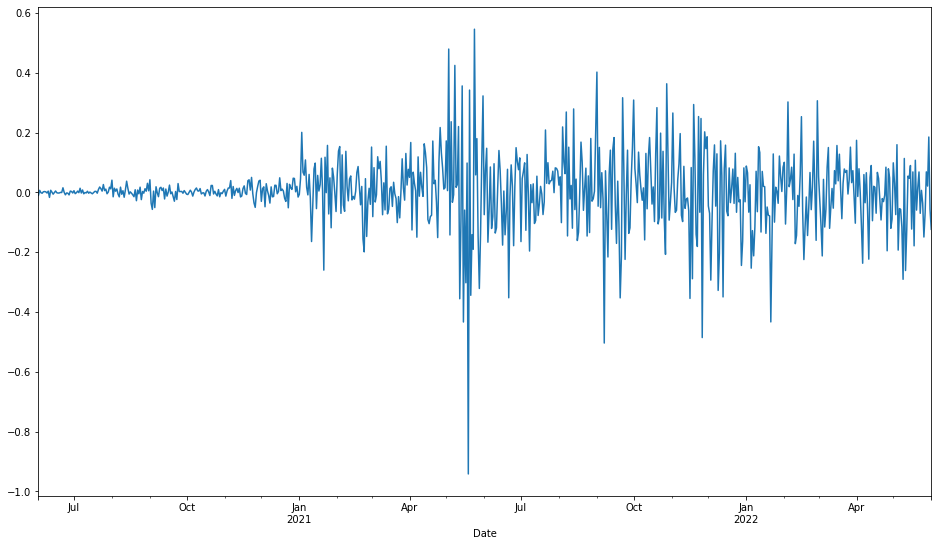

In [13]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [14]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.016000e+01
p-value                   7.551945e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [15]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Close'] = scaler.fit_transform(df_scaled['Close'].values.reshape(-1, 1))
df_scaled.head()

,Close
Date,
2020-06-01,-1.385862
2020-06-02,-1.393427
2020-06-03,-1.388465
2020-06-04,-1.389332
2020-06-05,-1.391700


## Chia dữ liệu thành tập train và tập test

In [16]:
interrupt = len(train)
interrupt

658

In [17]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(658, 1)
(73, 1)
(73,)


In [18]:
train.tail()

,Close
Date,
2022-03-16,2.77394
2022-03-17,2.81229
2022-03-18,2.93976
2022-03-19,2.94992
2022-03-20,2.86169


In [19]:
test.head()

,Close
Date,
2022-03-21,2.89163
2022-03-22,2.96964
2022-03-23,3.03612
2022-03-24,3.10925
2022-03-25,3.10351


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [20]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [21]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-913.124, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-907.683, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-911.324, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-911.165, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-908.972, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-907.394, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-907.566, Time=1.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-903.725, Time=3.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-922.453, Time=4.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-909.532, Time=2.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-917.209, Time=5.06 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-920.061, Time=4.80 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-913.182, Time=3.42 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-916.341, Time=5.22 sec
 ARIMA(2,1,3)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  658
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 467.821
Date:                Sat, 25 Jun 2022   AIC                           -923.641
Time:                        16:03:41   BIC                           -896.715
Sample:                             0   HQIC                          -913.203
                                - 658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8323      0.031    -58.241      0.000      -1.894      -1.771
ar.L2         -0.9116      0.030    -30.574      0.000      -0.970      -0.853
ma.L1          1.7710      0.040     43.845      0.000       1.692       1.850
ma.L2          0.7985      0.064     12.481      0.000       0.673       0.924
ma.L3         -0.0786      0.033     -2.399      0.016      -0.143      -0.014
sigma2         0.0141      0.000     32.315      0.000       0.013       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1344.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              34.13   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [22]:
pred = fitted.predict(len(test))
pred


array([2.84181832, 2.87508678, 2.8402839 , 2.87372582, 2.84417642,
       2.86783416, 2.85142334, 2.85992642, 2.85930643, 2.8526909 ,
       2.86537786, 2.84816212, 2.86814121, 2.84722729, 2.867335  ,
       2.84955672, 2.86380169, 2.85390733, 2.85905102, 2.858646  ,
       2.85469905, 2.86230035, 2.85197045, 2.86396865, 2.85140102,
       2.86349118, 2.852795  , 2.86137223, 2.85540682, 2.85851821,
       2.85825532, 2.85590063, 2.86045482, 2.85425666, 2.861462  ,
       2.85390986, 2.86117928, 2.85474403, 2.85990854, 2.85631199,
       2.85819397, 2.85802426, 2.85661958, 2.85934811, 2.8556291 ,
       2.85995614, 2.85541793, 2.85978878, 2.85591709, 2.85902672,
       2.85685838, 2.85799668, 2.85788765, 2.85704975, 2.85868445,
       2.85645299, 2.85905151, 2.85632443, 2.85895246, 2.85662312,
       2.85849546, 2.8571882 , 2.85787666, 2.8578069 , 2.85730712,
       2.85828648, 2.85694758, 2.85850806, 2.85686933, 2.85844946,
       2.85704805, 2.8581754 , 2.85738728])

# Vẽ đồ thị cho tập test và kết quả dự đoán

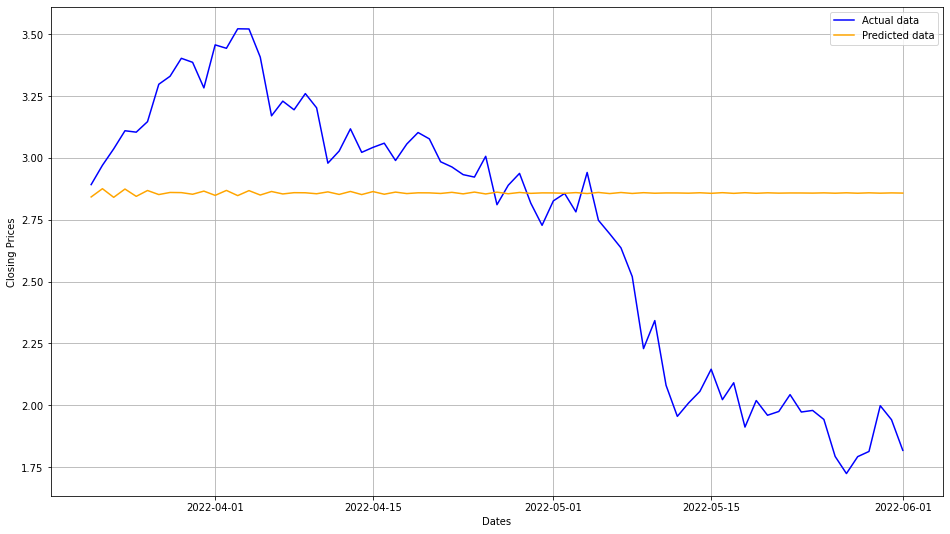

In [23]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [24]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


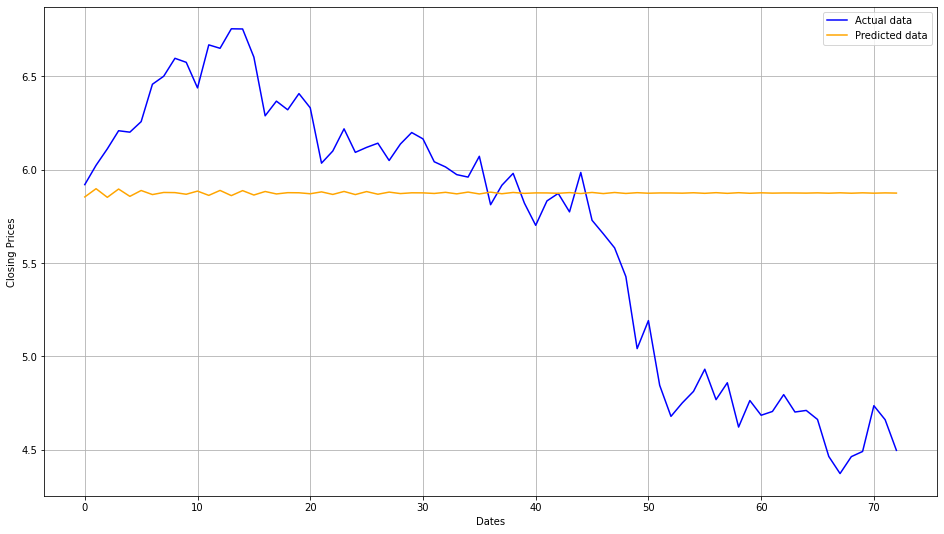

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [26]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 11.62%
RMSE: 0.75
R2: -0.08
